In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pathlib
import datetime
from math import ceil
from sklearn.metrics import classification_report
from src.data.dataset_loader import load_distracted_driver_detection_list, load_dataset_image_label
from src.data.image_label_loader import ImageLabelLoader
from src.evaluation import metrics
from src.utils.data_util import get_paths, sample_dataset
from src.preprocessing.standardizer import Standardizer
from src.visualization.history_plotter import plot_loss_acc_history_epoch
from src.visualization.weights_visualization import visualize_weights
from src.visualization.saliency_maps import show_saliency_maps
from src.solver.tensorflow_solver import TensorflowSolver

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = pathlib.Path("dataset/raw/imgs/train") # Train directory

X_train_filenames, X_val_filenames, y_train_labels, y_val_labels = load_distracted_driver_detection_list(val_size=0.2, split_on_driver=True, random_state=12)
train_paths = get_paths(data_dir, X_train_filenames, y_train_labels)
val_paths = get_paths(data_dir, X_val_filenames, y_val_labels)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

num_train = len(train_paths)
num_val = len(val_paths)
num_classes = len(class_names)

print(f'Training set size: {num_train}')
print(f'Validation set size: {num_val}')
print(f'Number of classes: {num_classes}')

Training set size: 17761
Validation set size: 4663
Number of classes: 10


In [3]:
CPU = '/cpu:0'
GPU = '/device:GPU:0'
physical_GPU = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(physical_GPU, True)

In [4]:
def preprocess_img(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label

In [5]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del train_dset
   del val_dset
   print('Clear previously loaded data.')
except:
   pass


BATCH_SIZE = 16
IMG_SHAPE = (128, 128, 3)
loader = ImageLabelLoader(class_names, IMG_SHAPE)
shuffle_size = ceil(num_train * 1.0)

# Force image load and preprocessing with specific device
with tf.device(CPU):
    # Train dataset input pipeline
    train_dset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dset = train_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Load from path to image, label
    train_dset = train_dset.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dset = train_dset.shuffle(buffer_size=shuffle_size, reshuffle_each_iteration=True)
    train_dset = train_dset.batch(BATCH_SIZE, drop_remainder=False)
    train_dset = train_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Validation dataset input pipeline
    val_dset = tf.data.Dataset.from_tensor_slices(val_paths)
    val_dset = val_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.map(preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.batch(BATCH_SIZE, drop_remainder=False)
    val_dset = val_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet').summary()

n[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, None, None, 1 525312      conv4_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_out (Add)          (None, None, None, 1 0           conv4_block1_0_conv[0][0]        
                                                                 conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block1_out[0][0]           
___________________________________________________________________________________________

In [6]:
class ResNet50V2(tf.keras.Model):
    def __init__(self, num_classes, img_shape):
        super(ResNet50V2, self).__init__()

        # Create the base model from the pre-trained model MobileNet V2
        self.base_model = tf.keras.applications.ResNet50V2(input_shape=img_shape,
                                                    include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
        
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal', kernel_regularizer='l2')
    
    def call(self, x, training=False):
        x = tf.keras.applications.resnet_v2.preprocess_input(x)
        x = self.base_model(x, training=False)

        scores = self.fc(x)

        return scores

In [7]:
resnet50v2_top_checkpoint_filepath = 'models/checkpoints/resnet50v2-top-best/checkpoint'
resnet50v2_all_checkpoint_filepath = 'models/checkpoints/resnet50v2-all-best/checkpoint'

In [11]:
model = ResNet50V2(num_classes, img_shape=IMG_SHAPE)
#model.base_model.trainable = False # Freeze weights
fine_tune_at = 100
for layer in model.base_model.layers[:fine_tune_at]:
    layer.trainable = False

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    resnet50v2_all_checkpoint_filepath, monitor='val_loss', 
    save_best_only=True, save_weights_only=True, save_freq='epoch')

optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-3, momentum=0.95, nesterov=True)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.sparse_categorical_accuracy])

with tf.device(GPU):
    trainer = model.fit(train_dset, epochs=1, validation_data=val_dset, callbacks=[checkpoint])

1111/1111 [==============================] - 110s 76ms/step - loss: 1.3354 - sparse_categorical_accuracy: 0.5793 - val_loss: 0.5901 - val_sparse_categorical_accuracy: 0.8417


In [12]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-6, momentum=0.95, nesterov=True)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.sparse_categorical_accuracy])

with tf.device(GPU):
    trainer = model.fit(train_dset, epochs=20, validation_data=val_dset, callbacks=[checkpoint])

Epoch 1/20
1111/1111 [==============================] - 111s 77ms/step - loss: 0.2263 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.5865 - val_sparse_categorical_accuracy: 0.8484
Epoch 2/20
1111/1111 [==============================] - 108s 77ms/step - loss: 0.1851 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.6002 - val_sparse_categorical_accuracy: 0.8422
Epoch 3/20
1111/1111 [==============================] - 106s 77ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.6074 - val_sparse_categorical_accuracy: 0.8402
Epoch 4/20
1111/1111 [==============================] - 106s 77ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.9813 - val_loss: 0.6111 - val_sparse_categorical_accuracy: 0.8394
Epoch 5/20
1111/1111 [==============================] - 107s 77ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.6129 - val_sparse_categorical_accuracy: 0.8396
Epoch 6/20
1111/1111 [==============================] - 107s 78ms/step - lo

In [ ]:
plot_loss_acc_history_epoch(trainer.history['loss'], trainer.history['val_loss'], trainer.history['sparse_categorical_accuracy'], trainer.history['val_sparse_categorical_accuracy'])

Log Loss: 0.4920328374638108
Val Accuracy: 0.848380870684109
Confusion Matrix:
[[440.   3.   3.   1.   0.   0.   2.   0.   8.   6.]
 [ 37. 374.   0.   2.   0.   0.  17.   0.  37.   3.]
 [  1.   1. 379.   0.   0.   9.  32.   0.  65.  12.]
 [  7.   0.   0. 476.   7.   0.   0.   0.   0.   0.]
 [  2.   0.   0.   4. 465.   1.  14.   0.  10.   0.]
 [  5.   0.   0.   0.   0. 500.   0.   0.   0.   0.]
 [  0.  16.   1.   0.   0.   3. 431.   0.  32.   0.]
 [  0.   4.   0.   0.   0.   0.   2. 355.  37.   2.]
 [ 20.   1.  31.   2.  14.   1.  13.   0. 320.   2.]
 [ 84.   0.   3.   2.   2.  92.   1.   0.  53. 216.]]
Confusion Matrix Heatmap:


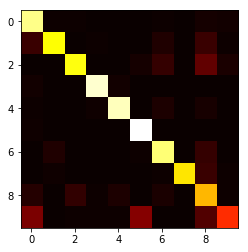

In [7]:
model = ResNet50V2(num_classes, img_shape=IMG_SHAPE)
resnet50v2_all_checkpoint_filepath = 'models/checkpoints/resnet50v2-all-best/checkpoint'
model.load_weights(resnet50v2_all_checkpoint_filepath)

y_true = []
y_pred = []
y_scores = []
for _,(X_batch, y_batch) in enumerate(val_dset.as_numpy_iterator()):
    y_true.append(y_batch)

    scores = model.predict(X_batch)
    y_scores.append(scores)
    prediction = np.argmax(scores, axis=1)
    y_pred.append(prediction)
    
y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)
y_scores = np.concatenate(y_scores)

# Log Loss Score
log_loss = metrics.log_loss(y_true, y_scores, scores_in_prob=True)
print(f"Log Loss: {log_loss}")

# Validation Accuracy
val_acc = metrics.accuracy(y_true, y_pred)
print(f"Val Accuracy: {val_acc}")

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Heatmap of the confusion matrix
print("Confusion Matrix Heatmap:")
plt.imshow(conf_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [8]:
class_desc = ['Safe Driving', 'Texting - Right', 'Talking on the phone - Right', 
'Texting - Left', 'Talking on the phone - Left', 'Operating The Radio', 
'Drinking', 'Reaching Behind', 'Hair and Makeup', 'Talking to Passanger']

print(classification_report(y_true, y_pred, target_names=class_desc))

                              precision    recall  f1-score   support

                Safe Driving       0.74      0.95      0.83       463
             Texting - Right       0.94      0.80      0.86       470
Talking on the phone - Right       0.91      0.76      0.83       499
              Texting - Left       0.98      0.97      0.97       490
 Talking on the phone - Left       0.95      0.94      0.95       496
         Operating The Radio       0.83      0.99      0.90       505
                    Drinking       0.84      0.89      0.87       483
             Reaching Behind       1.00      0.89      0.94       400
             Hair and Makeup       0.57      0.79      0.66       404
        Talking to Passanger       0.90      0.48      0.62       453

                    accuracy                           0.85      4663
                   macro avg       0.86      0.85      0.84      4663
                weighted avg       0.87      0.85      0.85      4663



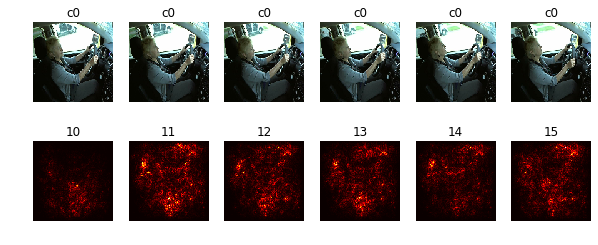

In [25]:
# Validation dataset without standarization
val_img_dset = tf.data.Dataset.from_tensor_slices(val_paths)
val_img_dset = val_img_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_img_dset = val_img_dset.batch(BATCH_SIZE, drop_remainder=False)
val_img_dset = val_img_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

X_val, y_val = next(iter(val_dset))
X_img_val, _ = next(iter(val_img_dset))

X_val = X_val.numpy()
y_val = y_val.numpy()
X_img_val = X_img_val.numpy()

mask = np.arange(10,16)
with tf.device('/cpu:0'):
    show_saliency_maps(model, X_val, y_val, X_img_val, mask, class_names)